# VAR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pyplot import figure


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS


<Figure size 1440x800 with 0 Axes>

In [2]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
ipe_df['contTime'] = pd.to_datetime(ipe_df.contTime)
data = ipe_df.drop(['contTime'], axis=1)
data.index = ipe_df.contTime

In [4]:
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1)

In [6]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [7]:
ipe_train = ipe_interp['2016':'2020']

In [8]:
ipe_test = ipe_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_3432\3605300567.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_test = ipe_interp['2021']


In [9]:
#missing value treatment
cols = ipe_train.columns
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = ipe_train.drop(['Turb_FNU'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([0.11861482, 0.09769685, 0.03403599, 0.00251116, 0.0003028 ])

In [10]:
#creating the train and validation set
train = ipe_train[:int(0.8*(len(ipe_train)))]
valid = ipe_train[int(0.8*(len(ipe_train))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(365)

# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

In [11]:
ipe_train

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
contTime,,,,,,
2016-01-01,3.102660,2.183437,0.414479,10.745625,3.837323,141.426042
2016-01-02,3.067604,1.616771,0.343750,10.761146,3.853583,141.876042
2016-01-03,2.683125,1.437579,0.331771,10.710938,4.008771,143.057292
2016-01-04,2.285312,1.182526,0.215104,10.576771,4.066344,143.029167
2016-01-05,2.225938,1.189271,0.254583,10.527188,4.116604,142.786458
...,...,...,...,...,...,...
2020-12-27,4.713474,0.442796,0.638495,6.953474,3.495432,138.068421
2020-12-28,4.657604,0.481429,0.708132,6.885625,3.478885,137.610417
2020-12-29,4.382604,0.449896,0.640842,6.684062,3.506271,137.482292


In [12]:
ipe_sqrt = np.sqrt(ipe_train)

C:\Users\harri\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


In [13]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,6):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Turb_FNU is :  3.8495093981166253
rmse value for Chloro_RFU is :  3.6754638003999145
rmse value for BGA_RFU is :  1.4074195771401035
rmse value for ODO_mgL is :  2.425986275515178
rmse value for Temp_C is :  2.5966514904420874
rmse value for Cond_muSCm is :  39.2998636672024


In [14]:
#make final predictions
model = VAR(endog=ipe_sqrt.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)
print(yhat)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[[ 2.62444678  0.82974155  0.75579157  2.72960998  1.80012567 11.67179038]
 [ 2.9842777   1.0443416   0.78197392  2.79714629  1.86505079 11.69731246]
 [ 2.22370313  1.29554039  0.9966524   2.5226583   1.9611574  11.69016681]
 ...
 [-0.18217341 -2.4276754  -0.98673219  1.23570234  3.51720044 13.68936862]
 [-0.10636492 -2.61012088 -0.9966249   1.25236562  3.47996432 13.72708395]
 [ 0.88068061 -1.95032271 -0.26404441  1.34971202  3.36412208 13.71663575]]


In [15]:
model_fit.endog_lagged

array([[ 1.        ,  1.13435922,  0.3127499 , ...,  3.27805201,
         1.9589086 , 11.89226815],
       [ 1.        ,  1.14641652,  0.30838963, ...,  3.28041855,
         1.96305459, 11.91117298],
       [ 1.        ,  1.13568995,  0.31490739, ...,  3.27275687,
         2.00219151, 11.96065599],
       ...,
       [ 1.        ,  2.15814832,  0.69385054, ...,  3.07509521,
         1.85845437, 10.94930904],
       [ 1.        ,  2.09346702,  0.67074275, ...,  3.08484197,
         1.87053357, 10.93131968],
       [ 1.        ,  2.02199858,  0.64959924, ...,  3.04274211,
         1.88978294, 11.03450112]])

C:\Users\harri\AppData\Local\Temp\ipykernel_3432\3284612793.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ipe_interp['2020'])


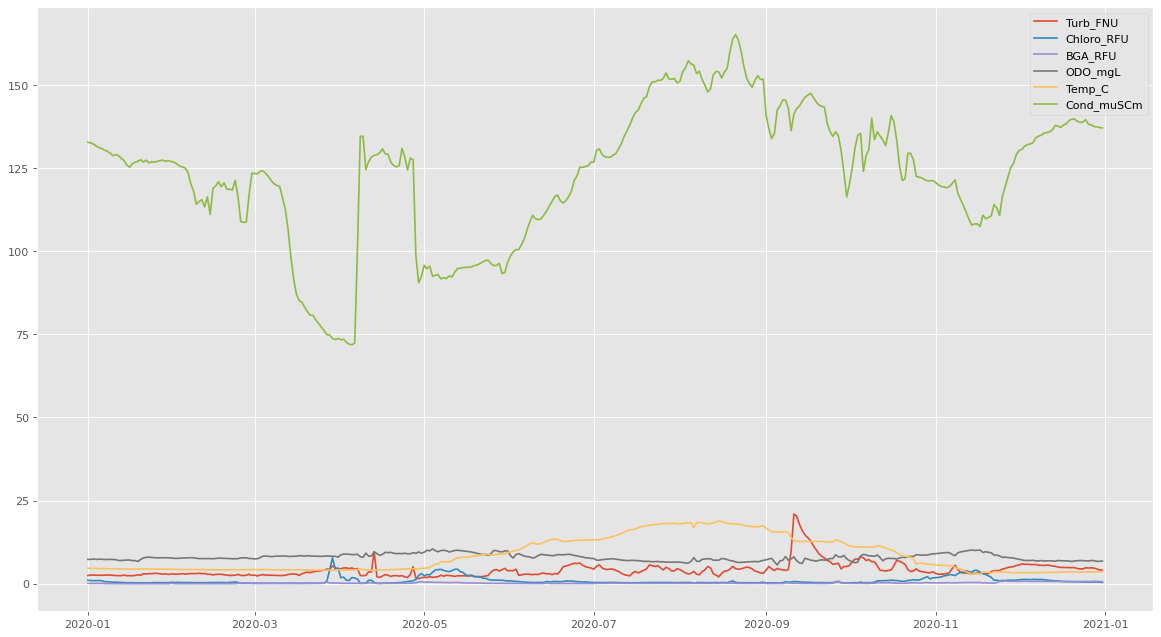

In [28]:
figure(figsize=(18,10), dpi=80)

plt.plot(ipe_interp['2020'])
plt.legend(ipe_interp)

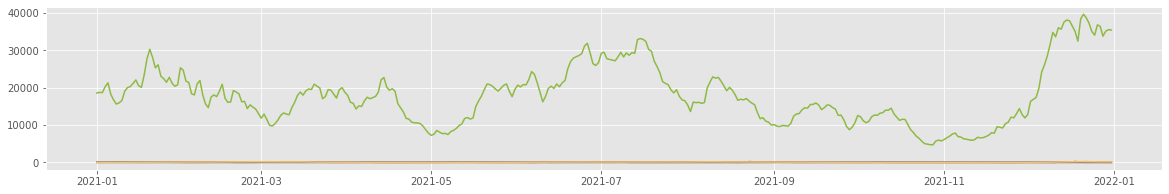

In [29]:
plt.plot(yhat**2)

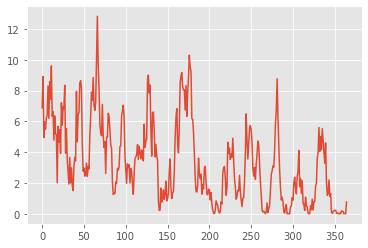

In [17]:
plt.plot((yhat[:,0]**2), label='Predicted')

In [18]:
dibrinse = (ipe_test-yhat)**2
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

#verify the right way to do this

Turb_FNU        3.581602
Chloro_RFU      8.776376
BGA_RFU         3.024561
ODO_mgL         5.760254
Temp_C          8.339270
Cond_muSCm    114.060146
dtype: float64

In [19]:
yhat = pd.DataFrame(yhat**2)
yhat.set_index(ipe_test.index, inplace=True)

In [20]:
yhat

,0,1,2,3,4,5
contTime,,,,,,
2021-01-01,6.887721,0.688471,0.571221,7.450771,3.240452,136.230691
2021-01-02,8.905913,1.090649,0.611483,7.824027,3.478414,136.827119
2021-01-03,4.944856,1.678425,0.993316,6.363805,3.846138,136.660000
2021-01-04,5.959072,0.280657,0.485750,7.058852,4.239706,142.365091
2021-01-05,5.492042,0.161425,0.220854,7.197549,4.656362,145.860271
...,...,...,...,...,...,...
2021-12-27,0.145090,9.561164,0.844962,1.678223,12.110625,190.766071
2021-12-28,0.000220,7.533711,0.977486,1.703881,12.665262,183.765689
2021-12-29,0.033187,5.893608,0.973640,1.526960,12.370699,187.398813


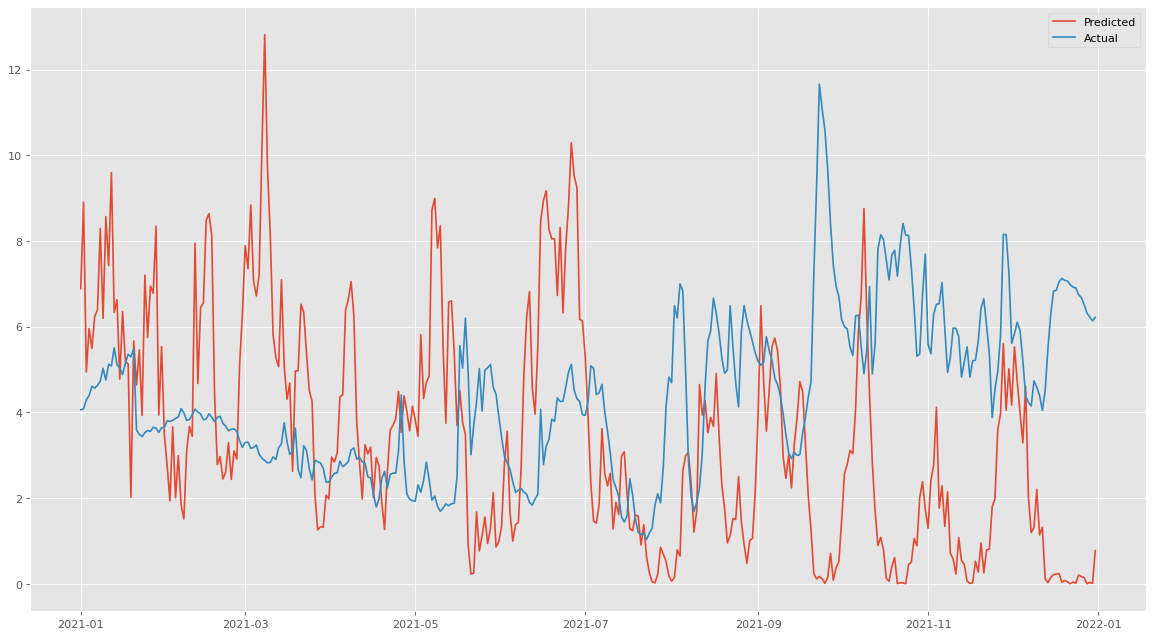

In [30]:
figure(figsize=(18,10), dpi=80)


plt.plot((yhat[0]), label='Predicted')
plt.plot(ipe_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.legend()

The above is the predicted values for Turbidity 

In [33]:
yhat.columns = ipe_test.columns

In [34]:
yhat

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
contTime,,,,,,
2021-01-01,6.887721,0.688471,0.571221,7.450771,3.240452,136.230691
2021-01-02,8.905913,1.090649,0.611483,7.824027,3.478414,136.827119
2021-01-03,4.944856,1.678425,0.993316,6.363805,3.846138,136.660000
2021-01-04,5.959072,0.280657,0.485750,7.058852,4.239706,142.365091
2021-01-05,5.492042,0.161425,0.220854,7.197549,4.656362,145.860271
...,...,...,...,...,...,...
2021-12-27,0.145090,9.561164,0.844962,1.678223,12.110625,190.766071
2021-12-28,0.000220,7.533711,0.977486,1.703881,12.665262,183.765689
2021-12-29,0.033187,5.893608,0.973640,1.526960,12.370699,187.398813


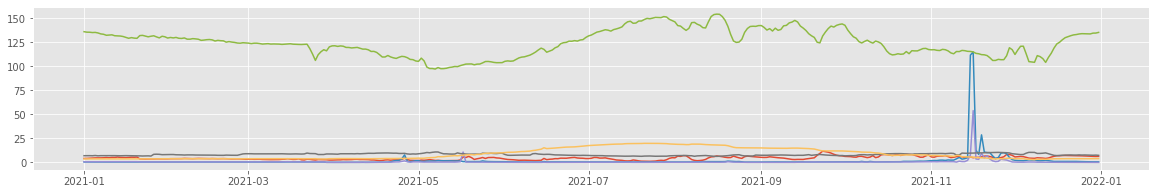

In [35]:
plt.plot(ipe_test)

In [37]:
# redo this within the scope of one dataset

jimmies = OLS(exog=yhat, endog=ipe_test['Turb_FNU'])
jim = jimmies.fit()
print(jim.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                              269.9
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                   1.01e-129
Time:                        14:30:28   Log-Likelihood:                         -774.52
No. Observations:                 365   AIC:                                      1561.
Df Residuals:                     359   BIC:                                      1584.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [38]:
jimmies.params

AttributeError: 'OLS' object has no attribute 'params'

As others have stated, you need to have a common frequency of measurement (i.e. the time between observations). With that in place I would identify a common model that would reasonably describe each series separately. This might be an ARIMA model or a multiply-trended Regression Model with possible Level Shifts or a composite model integrating both memory (ARIMA) and dummy variables. This common model could be estimated globally and separately for each of the two series and then one could construct an F test to test the hypothesis of a common set of parameters.